# Ulysees Compass

Often when building models, we have to compare more complex more accurate models, with less accurate, but simpler models. How are we to trade one criteria against another? This section describes some of the most commonly used tools for coping with this trade off.

Instead of always choosing the most simple model, using ockhams razor, think of Ulysses compass. Ulysses was the hero of Homer’s Odyssey. During his voyage, Ulysses had to navigate a narrow straight between the many- headed beast Scylla—who attacked from a cliff face and gobbled up sailors—and the sea monster Charybdis—who pulled boats and men down to a watery grave. Passing too close to either meant disaster. In the context of scientific models, you can think of these monsters as representing two fundamental kinds of statistical error:

(1) The many-headed beast of overfitting, which leads to poor prediction by learn- ing too much from the data

(2) The whirlpool of underfitting, which leads to poor prediction by learning too little from the data

Our job is to carefully navigate these monsters. There are two common families of approaches. This first approach is to use a REGULARIZING PRIOR to tell the model not to get too excited by the data. The second approach is to use some scoring device, like INFORMATION CRITERIA or CROSS VALIDATION, to model the predictive task and estimate predictive accuracy.


## The problem with parameters

In the previous chapters, we saw how adding variables and parameters to a model can help to reveal hidden effects and improve estimates. You also saw that adding variables can hurt, in particular when we lack a trusted causal model. Colliders are real. But sometimes we don't care about causal inference. Maybe we just want to make good predictions. Consider for example the gradparent-parent-child example from the previous chapter. Just adding all the variables to the model will give us a good predictive model in that case. That we don't understand what is going on is irrelevant. So is just adding everything to the model okay?

NO

There are two related problems with this. The first is that adding parameters - making the model more complex - nearly always improves the fit of a model to the data. the data used to fit the model. There are many such measures, each with its own foibles. In the context of linear Gaussian models, R2 is the most common measure of this kind. Often described as “variance explained,” R2 is defined as:

2 var(outcome) − var(residuals) var(residuals) R= =1−
  var(outcome) var(outcome)
  
Being easy to compute, R2 is popular. But like other measures of fit to sample, R2 increases as more predictor variables are added. This is true even when the variables you add to a model are just random numbers, with no relation to the outcome. So it’s no good to choose among models using only fit to the data.

Second, while more complex models fit the data better, they often predict new data worse

## Overfitting

Here is an example of overfitting. The data displayed below are average brain volumes and body masses for seven homonin species. 

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from patsy import dmatrix
from scipy import stats
from scipy.special import logsumexp

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [2]:
data = {'species' : ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens'],
'brain' : [438, 452, 612, 521, 752, 871, 1350],
'mass' : [37., 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]}
d = pd.DataFrame(data)
d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


<AxesSubplot:xlabel='mass', ylabel='brain'>

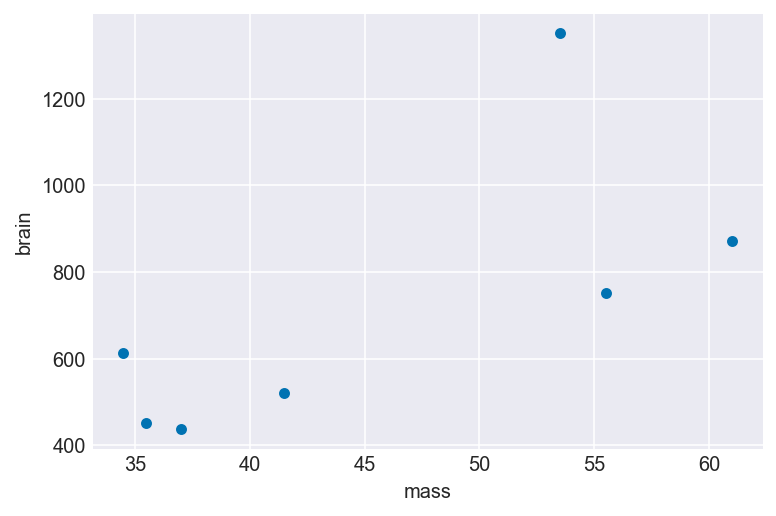

In [6]:
d.plot(kind='scatter', x='mass', y='brain')

Lets fit a series of increasingly complex model families and see which function fits the data best. LEts start with a linear one. It will be the first model we consider. Before writing out the model, lets rescale the variables. Recall from earlier chapters that rescaling predictor and outcome varibles is often helpful in getting the model to fit and in specifying and understanding he priors. In this case, we want to standardise body mass, and rescale brain volume so that the largest observed value is 1. Why not standardise brain volume as well? Because we want to preserve zero as a reference point. No Brain at all. You can;t have negative brain. I don't think

In [12]:
d['mass_std'] = (d['mass'] - d['mass'].mean())/d['mass'].std()
d['brain_std'] = d['brain']/max(d['brain'])

Now, here is a definition of a linear model 

In [43]:
m_7_1 = smf.ols("brain_std ~ mass_std", data=d).fit()
m_7_1.summary()

/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Tue, 12 Jan 2021   Prob (F-statistic):             0.0798
Time:                        09:44:12   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.347       0.710
mass_std       0.1671      0.076      2.192      0.080      -0.029       0.363
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now lets focus on R^2, the proportion of variance "explained" by the model. What is really meant here is that the linear model retrodicts some proportion of total variation in the outcome data it was fit to. The remaining variation is just the variation of the residuals. The point of this example is not to praise R^2 but to bury it. But we still need to compute it before burial. This is thankfully easy. We just compute the posterior predictive distribution for each obervation. Then we subtract each observation from its prediction to get a residual. Then we need the variance of both these residuals and outcome variable. This means the 'actual' empirical variance. Not the variance that is returned with a 'variance' function, which is a frequentist estimator and therefore has the wrong denominator. So we'll compute variance the old fashioned way; the average squared deviation from the mean.

In principle, the bayesian approach mandates that we do this for each sample from the posterior. But R^2 is only computed at the mean predictions. So we'll do that as well here.

In [44]:
1 - m_7_1.resid.var() / d['brain_std'].var()

0.49015804794908413

In [46]:
def R2_is_bad(model):
    return 1 - model.resid.var() / d['brain_std'].var()


R2_is_bad(m_7_1)

0.49015804794908413

Now for some more complex models to compare to m7.1 We'll consider five more models, each more complex than the last. Each of these models will just be a polynomial of a higher degree.

In [48]:
m_7_2 = smf.ols("brain_std ~ mass_std + I(mass_std**2)", data=d).fit()

m_7_3 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)", data=d).fit()
m_7_4 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)",
    data=d,
).fit()
m_7_5 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5)",
    data=d,
).fit()
m_7_6 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5) + I(mass_std**6)",
    data=d,
).fit()

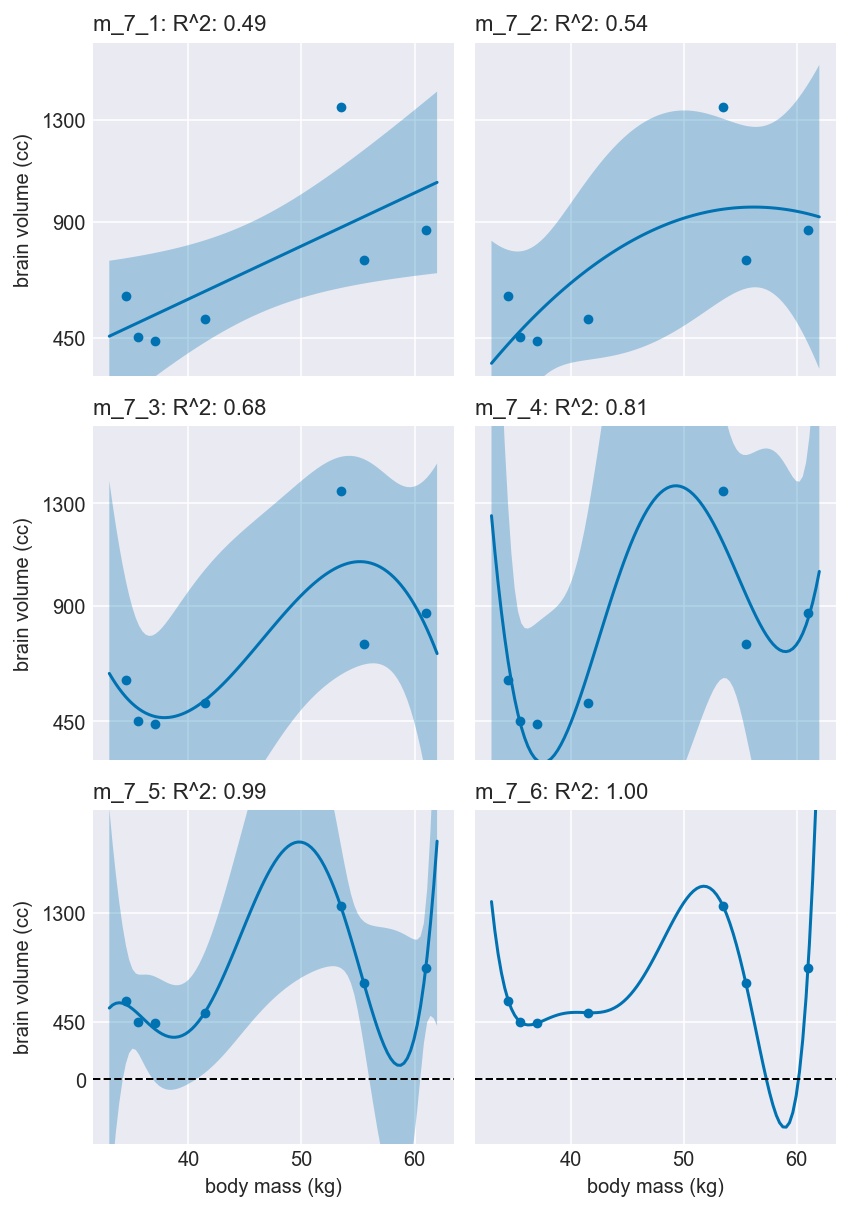

In [50]:
models = [m_7_1, m_7_2, m_7_3, m_7_4, m_7_5, m_7_6]
names = ["m_7_1", "m_7_2", "m_7_3", "m_7_4", "m_7_5", "m_7_6"]

mass_plot = np.linspace(33, 62, 100)
mass_new = (mass_plot - d.mass.mean()) / d.mass.std()

fig, axs = plt.subplots(3, 2, figsize=[6, 8.5], sharex=True, sharey="row")

for model, name, ax in zip(models, names, axs.flat):
    prediction = model.get_prediction({"mass_std": mass_new})
    pred = prediction.summary_frame(alpha=0.11) * d.brain.max()

    ax.plot(mass_plot, pred["mean"])
    ax.fill_between(mass_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.3)
    ax.scatter(d.mass, d.brain, color="C0", s=15)

    ax.set_title(f"{name}: R^2: {model.rsquared:.2f}", loc="left", fontsize=11)

    if ax.is_first_col():
        ax.set_ylabel("brain volume (cc)")

    if ax.is_last_row():
        ax.set_xlabel("body mass (kg)")

    if ax.is_last_row():
        ax.set_ylim(-500, 2100)
        ax.axhline(0, ls="dashed", c="k", lw=1)
        ax.set_yticks([0, 450, 1300])
    else:
        ax.set_ylim(300, 1600)
        ax.set_yticks([450, 900, 1300])

fig.tight_layout()

You can see from looking at the paths of the predicted means that the higher degree polynomials are increasingly absurd. The fit is perfect, but the model is ridiculous. Why does a sixth degree polynomial fir perfectly? because it has enough parameters to assign one to each point of data. If you edopt a model family with enough parameters, you can fit the data exactly. But such a model will make rather absurd predictions for yet-to-be-observed cases.

### Too few parameters hurts too
The overfit polynomial models manage to fit the data extrememly well, but they suffer for this within sample accuracy by making nonsensical out of sample predictions. In contrast UNDERFITTING produces models are are inaccurate both within and out of sample. They have learned too little, failing to recover regular features from the sample.

## Bias-Variance Trade Off
The underfitting/overfitting dichotomy is often described as the BIAS/VARIANCE TRADEOFF. While not exactly the same distrinction, the bias-variance trade-off addresses the same problem. "Bias" is related to underfitting which "variance" is related to overfitting. These terms are confusing though, because they are used in many different ways for different contexts, even within statistics. The term "Bias" also sounds like a bad thing, even though increasing biad often leads to better predictions. 

### Information entropy

The uncertainty contained in a probability distribution is the average log-probability of an event.

"Event" here might refer to the type of weather, like rain or shine, etc. In order to demystify the situation, we can compute the information entropy for the weather, suppose the true probabilities of rains and shine are p1 = 0.3 and p2 = 0.7 respectively.

In [51]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

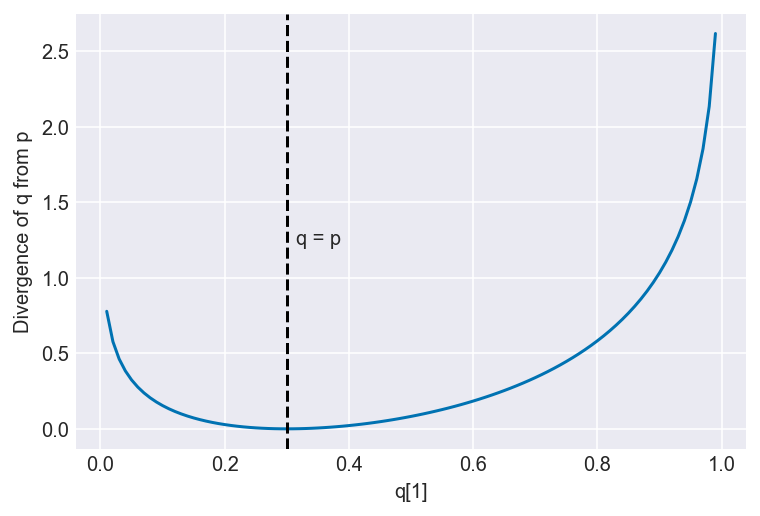

In [56]:
# Figure 7.5
p = np.array([0.3, 0.7])  # probability of it raining and not raining
q = np.arange(0.01, 1, 0.01) # probability of it raining in real life
inv_q = 1-q  # probability of it not raining in real life

DKL = np.sum(p * np.log(p / np.array([q, inv_q]).T), 1)

plt.plot(q, DKL)
plt.xlabel("q[1]")
plt.ylabel("Divergence of q from p")
plt.axvline(0.3, ls="dashed", color="k")
plt.text(0.315, 1.22, "q = p");

## Ridge Regression
Linear models in which the slope parameters use Gaussian priors centered at zero, are sometimes known as ridge regression. Ridge regression typically takes as an input a precision (lambda) that essentially describes the narrowness of the prior.  lambda >0 results in less overfitting. However just as with the bayesian version, if lambda is too large, we risk underfitting. While not originally developed as bayesian, ridge regression is another example of how a statistical procedure can be understoof from both bayesian and non-bayesian perspectives. Ridge regression does not compute a posterior distribution. Instead it uses a modification of OLS that stitches lambda into the usual matrix algenbra formula for the estimates. Despite how easy it is to use regularisation, most traditional statistical methods use no regularisation at all.

## WAIC Calculations
To consider how WAIC calculations actually work, lets fit a model to some sample data


In [57]:
data = pd.read_csv("cars.csv", sep=",", index_col=0)

In [60]:
with pm.Model() as m:
    a = pm.Normal("a", mu=0, sd=100)
    b = pm.Normal("b", mu=0, sd=10)
    sigma = pm.Uniform("sigma", 0, 30)
    mu = pm.Deterministic("mu", a + b * data["speed"])
    dist = pm.Normal("dist", mu=mu, sd=sigma, observed=data["dist"])
    m = pm.sample(5000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 1 divergences: 100%|██████████| 60000/60000 [00:29<00:00, 2058.04draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6105257697007913, but should be close to 0.8. Try to increase the number of tuning steps.


In [61]:
# We'll need the log-likelihood of each observation i at each sample s from the posterior

n_samples = 1000
n_cases = data.shape[0]
logprob = np.zeros((n_cases, n_samples))

for s in range(0, n_samples):
    mu = m["a"][s] + m["b"][s] * data["speed"]
    p_ = stats.norm.logpdf(data["dist"], loc=mu, scale=m["sigma"][s])
    logprob[:, s] = p_

You end up with a 50x1000 matrix of log liklihoods, with observations in rows and samples in columns. Now to compute lppd, the bayesian deviance, we average the samples in each row, take the log, and add the logs together. However, to do this with precision, we need to do all of the averaging on the log scale. Then we can just subtract the log from the number of samples. This computes the log of the average

In [65]:
n_cases = data.shape[0]
lppd = np.zeros(n_cases)
for a in range(1, n_cases):
    lppd[a] = logsumexp(logprob[a]) - np.log(n_samples)

Now for the penalty term, p(waic). This is more straightforward, as we just compute the variance across samples for each observation, then add these together.

In [66]:
pWAIC = np.zeros(n_cases)
for i in range(1, n_cases):
    pWAIC[i] = np.var(logprob[i])
    
-2 * (sum(lppd) - sum(pWAIC))

413.03419609407194

## Model comparison

How do we use regularising priors and CV/PSIS/WAIC? A very common use of cross validation and information criteria is to perform MODEL SELECTION, which means choosing the model with the lowest information criterion value and discard the others. But you should never do this. This kind of selection procedure discards the information about relative model accuracy contained in the differences amoung CV/PSIS/WAIC values. Why are the differences useful? Because sometimes the differences are large and sometimes they are small. 

So instead of model selection, we'll focus on MODEL COMPARISON. This is a more general approach that uses multiple models to understand both how different variables influence predictions and in combination with a causal model, implied conditional independencies amoung varaibles help us to infer causal relationships.

Lets work through two examples. The first emphasises the distrinction between comparing predictive performance versus comparing then in order to infer causation. The second emphasises the pointwise nature of model comparison and what inspecting individual points can reveal about model performance and mis-specification. The second also introduces a more rebust alternative to Gaussian regression.

### Model mis-selection

Note: We need to re-create models 6.6 6.7 and 6.8 for this bit

In [4]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_6_trace = pm.sample(5000, tune=10000)

with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment + bf * d.fungus

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_7_trace = pm.sample(5000, tune=10000)

with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_8_trace = pm.sample(5000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5451.73draws/s]
The acceptance probability does not match the target. It is 0.7093460595971205, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, bt, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3394.65draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bt, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3976.96draws/s]


In [7]:
az.waic(m_6_7_trace, m_6_7, scale="deviance")

Computed from 20000 by 100 log-likelihood matrix

        Estimate       SE
IC_waic   365.71    13.35
p_waic      3.29        -

The first value (365) is the guess for the out of sample deviance. The other values are p_wAIC and the standard error of the WAIC value.

In [9]:
compare_df = az.compare(
    {
        "m_6_6": m_6_6_trace,
        "m_6_7": m_6_7_trace,
        "m_6_8": m_6_8_trace,
    },
    method="pseudo-BMA",
    ic="waic",
    scale="deviance",
)
compare_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_6_7,0,365.705706,3.293643,0.000000,1.0,13.349394,0.000000,False,deviance
m_6_8,1,433.467888,2.442875,67.762182,0.0,10.251405,11.320604,False,deviance
m_6_6,2,445.054665,1.655180,79.348959,0.0,11.670206,13.500200,False,deviance


What do all these numbers mean? The first column contains the WAIC values. Smaller values are better, and the models  are ordered by WAIC, from best to worst. The model that includes the fungus variable has the smallest WAIC, as promised. The second term, pWAIC is the penality terms of WAIC. These values are close to, but slightly below the number of dimensions in the posterior of each model, which is to expected in linear regressions with regularising priors.

The next column d_waic is the difference between each models WAIC and the best WAIC in the set. So its zero for the best model and then the differences with the other models tell you how far apart each is from the top model. The intercept model, 6.6 is about 12 units worse than 6.8. Are these big differences or small differences? one way to answer that is to ask a clearer question: are the models easily distinguished by their expected out-of-sample accuracy? To answer the question, we need to consider the error in thr WAIC esimates. Since we don't have a target sample, these are just guesses, and we know from the simulations that there is a lot of variation in WAIC's error.

This is what the last two columns, SE and dSE are there to help us with. SE is the approximate standard error of each WAIC. In a very approximate sense, we expect out-of-sample accuracy to be normally distributed with a mean equal to the reported WAIC value and a standard deviation equal to ther standard error. This approximation is quite bad, when the sample is small. But it is still better than the older criteria like AIC, which provide no way to gauge their error. 

Now to judge whether two models are easy to distinguish, we don't use their standard errors but rather the standard error of their difference. What does that mean? Just like each WAIC value, each difference in WAIC values also has a standard error. To compute the standard error of the difference between models 6.7 and 6.8, we just need the pointwise breakdown of the WAIC values.

In [10]:
waic_m_6_7 = az.waic(m_6_7_trace, pointwise=True, scale="deviance")
waic_m_6_8 = az.waic(m_6_8_trace, pointwise=True, scale="deviance")

# pointwise values are stored in the waic_i attribute.
diff_m_6_7_m_6_8 = waic_m_6_7.waic_i - waic_m_6_8.waic_i

n = len(diff_m_6_7_m_6_8)

np.sqrt(n * np.var(diff_m_6_7_m_6_8)).values

array(11.32060365)

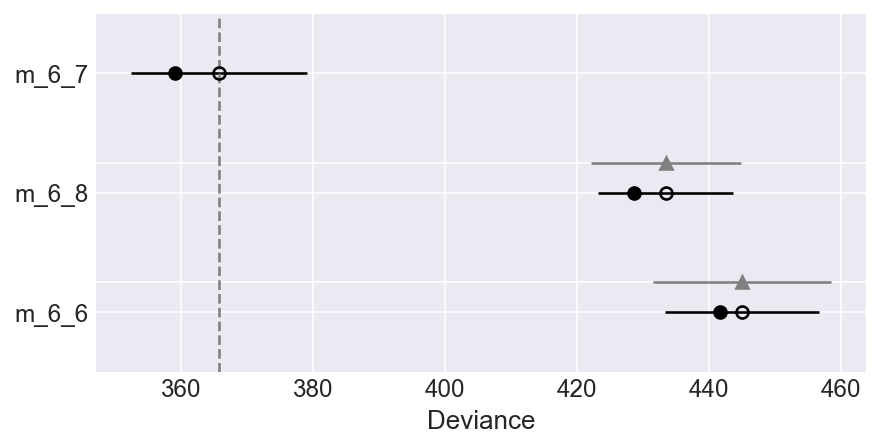

In [11]:
az.plot_compare(compare_df);

The filled in points are the in-sample deviance values. The open points are WAIC values. Notice that naturall each model does better in sample than it expected to do out of sample. The line segments show the standard error of each WAIC. These are the values in the column labelled SE in the table above. So you can probably see how much better 6.7 is to 6.8. What we really want however is the standard error of the difference in WAIC between the two models. That is shown by the lighter line segment with the triangle in it.


So yes, these model are very easy to distinguish by expected out-of-sample accuracy. Model 6.7 is a lot better

In [12]:
waic_m_6_6 = az.waic(m_6_6_trace, pointwise=True, scale="deviance")

diff_m6_6_m6_8 = waic_m_6_6.waic_i - waic_m_6_8.waic_i

n = len(diff_m6_6_m6_8)

np.sqrt(n * np.var(diff_m6_6_m6_8)).values

array(8.65635312)

In [13]:
dataset_dict = {"m_6_6": m_6_6_trace, "m_6_7": m_6_7_trace, "m_6_8": m_6_8_trace}

# compare all models
s0 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]
# the output compares each model to the 'best' model - i.e. two models are compared to one.
# to complete a pair-wise comparison we need to compare the remaining two models.

# to do this, remove the 'best' model from the input data
del dataset_dict[s0.index[0]]

# re-run compare with the remaining two models
s1 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]

# s0 compares two models to one model, and s1 compares the remaining two models to each other
# now we just nee to wrangle them together!

# convert them both to dataframes, setting the name to the 'best' model in each `compare` output.
# (i.e. the name is the model that others are compared to)
df_0 = s0.to_frame(name=s0.index[0])
df_1 = s1.to_frame(name=s1.index[0])

# merge these dataframes to create a pairwise comparison
pd.merge(df_0, df_1, left_index=True, right_index=True)

,m_6_7,m_6_8
m_6_8,11.320604,0.000000
m_6_6,13.500200,8.656353


## WAIC Metaphor.

Think of models as race horsess. In any particular race, the best horse may not win. But its more likely to win than is the worst horse. And when the winning horse finishes in half the time of the second place horse, you can be pretty sure the winning horse is also the best. But if instead its a photo finish, with a near tie between first place and second place, then its much harder to be confident about which horse if best. WAIC values are analagous to these race times. The smaller the better, and ther distances between the horses/models are informative. Akaike weights transform differences in finishing time to probabilities of being the best model/horse on future data/races. But if the track conditions or jockey changes, these probabilities may mislead. Forecasting future racing prediction based upon a single race/fit carries no guarantees

## Outliers and other illusions

In the divorce example, we saw in the posterior predictions that a few states were very hard for the model. The state of idaho in particular was something of an OUTLIER. Individual points like idaho tend to be very influential in ordinary regression models. Lets see how PSIS and WAIC represent that importance.

We will need to re-create these models for this

In [14]:
d = pd.read_csv("WaffleDivorce.csv", delimiter=";")

d["A"] = stats.zscore(d["MedianAgeMarriage"])
d["D"] = stats.zscore(d["Divorce"])
d["M"] = stats.zscore(d["Marriage"])

In [15]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,A,D,M
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.612445,1.671000,0.022874
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.693671,1.560044,1.565536
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.206314,0.616916,0.049472
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.424706,2.114824,1.671927
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.605947,-0.936470,-0.269700


In [16]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)

    mu = a + bA * d["A"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_1_trace = pm.sample()

with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_2_trace = pm.sample()

with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"] + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1281.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1147.67draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1171.21draws/s]


## Reviewing the models
Because this analysis was one a whole ago, lets remind ourselves of the different models, and what they told us

Model 0 - M5_1 = A regression that related age of marriage to divorce rate

model 1 - M5_2 = A regression that related marriage rate to divorce rate

model 2 - M5_2 = A regression that included both marriage rate and age of marriage when predicting divorce rate

Other symbols: a = the intercept
               sigma = the standard deviation from the mean (with the mean being defined as a+bx)
               
Recap: This group of models told us that age of marriage was the most important variable, and it acted as a confound between marriage rate and divorce rate. Marriage rate was found to be not very important when marriage age was considered

array([<AxesSubplot:title={'center':'94.0% Credible Interval'}>],
      dtype=object)

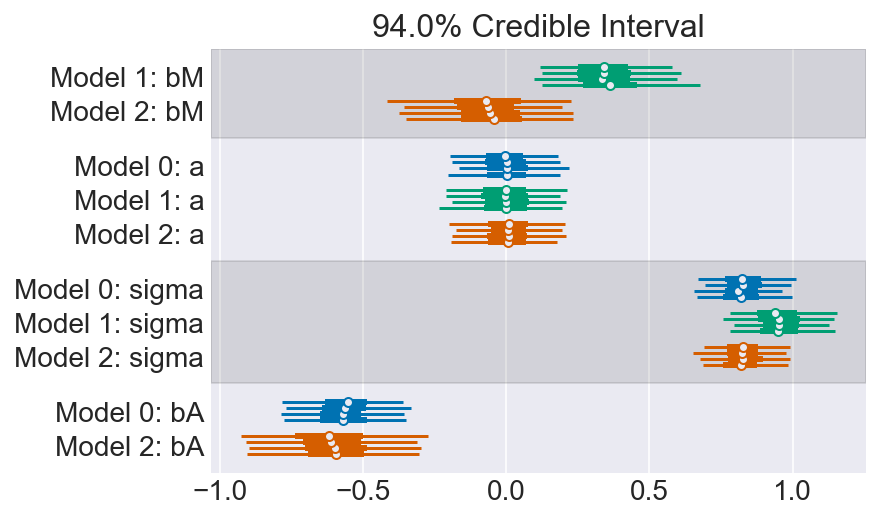

In [36]:
az.plot_forest([m_5_1_trace,
                 m_5_2_trace,
                 m_5_3_trace],
                figsize=[6, 3.5])

In [18]:
az.compare(
    {"m_5_1": m_5_1_trace, "m_5_2": m_5_2_trace, "m_5_3": m_5_3_trace},
    scale="deviance",
    ic = 'loo',
)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_5_1,0,127.091604,3.790583,0.000000,0.626407,12.710291,0.000000,False,deviance
m_5_3,1,128.618459,4.759931,1.526854,0.300202,10.043596,0.686318,False,deviance
m_5_2,2,140.567940,3.091145,13.476336,0.073391,12.771487,9.138848,False,deviance


There are two important things to consider here. First note that the model that omits marriage rate (5_1) lands on top. This is because marriage rate has very little association with the outcome. So the model that omits it has slightly better expected out of sample performance, even though it actually fits the sample slightly worse than m5.3, the model with both predictors.

/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/stats/stats.py:1194: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


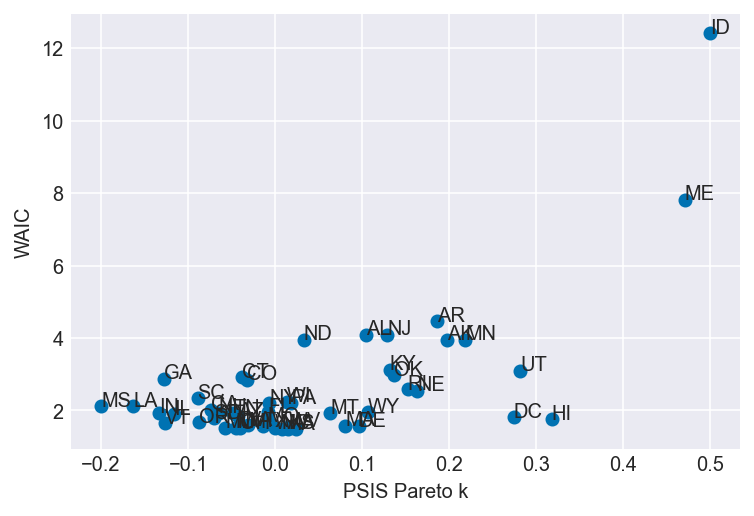

In [31]:
psis_m_5_3 = az.loo(m_5_3_trace, pointwise=True, scale="deviance")
waic_m_5_3 = az.waic(m_5_3_trace, pointwise=True, scale="deviance")

# Figure 7.10
plt.scatter(psis_m_5_3.pareto_k, waic_m_5_3.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC");



for i in range(len(psis_m_5_3.pareto_k)):
    plt.annotate(d['Loc'].iloc[i], (psis_m_5_3.pareto_k[i], waic_m_5_3.waic_i[i]))

In [38]:
az.loo(m_5_3_trace, pointwise=True, scale="deviance")

Computed from 2000 by 50 log-likelihood matrix

       Estimate       SE
IC_loo   128.62    12.75
p_loo      4.76        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

You might see some warning about WAIC or PSIS being unreliable at some samples. These samples tend to be outliers with unlikely values, according to the model. As a result, they are highly influential and make it difficult to estimate out of sample predictive accuracy. Why? Because any new sample is unlikely to contain these same outliers, and since these outliers are highly influential, thet could make out of sample predictions worse than expected. 

Lets look at the individual states, to see which are causing the problem


Look at the figure above. Highly influential points and out of sample predictions. The horizontal axis is WAICs penalty term. The state of idaho has an extremely unlikley value, according to the model. As a result it has a very high pareto k and large WAIC penalty. Points like these are highly influential and potentially hurt prediction.

## So what can be done about this?
There is a tradition of dropping outliers. People sometimes drop outliers even before a model is fit, based only on standard deviations from the mean outcome value. You should never do that - a point can only be unexpected and influential in light of a model. After you fit a model, the picture changes. If there are only a few outliers, and you are sure to report results both with and without them, dropping outliers might be ok. But if there are several outliers, and we really need to model them, then what?

A basic problem here is that the gausian error model is easily surprised. Gaussian distributions hae very thin tails. This means that very little probability mess is given to observations far from the mean. Many natural phenomena do have very thin tails like this. Human height is a good example. But many phenomena do not. Instead many phenomena have thicker tails with rare, extrama observations. There are not measurement errors, but real events containing information about natural process.

One way to both use these extreme observations and reduce their influence is to employ some kind of ROBUST REGRESSION. A common and useful kind of robust regression is to replace the gaussian model with a thicker tailed distribution like STUDENT TS distribution. 

In [32]:
with pm.Model() as m_5_3t:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"] + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.StudentT("D", 2, mu, sigma, observed=d["D"]) #divorce rate is now a T dist as opposed to normal

    m_5_3t_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1137.57draws/s]


In [33]:
az.loo(m_5_3t_trace, pointwise=True, scale="deviance")

Computed from 2000 by 50 log-likelihood matrix

       Estimate       SE
IC_loo   133.18    10.70
p_loo      5.33        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

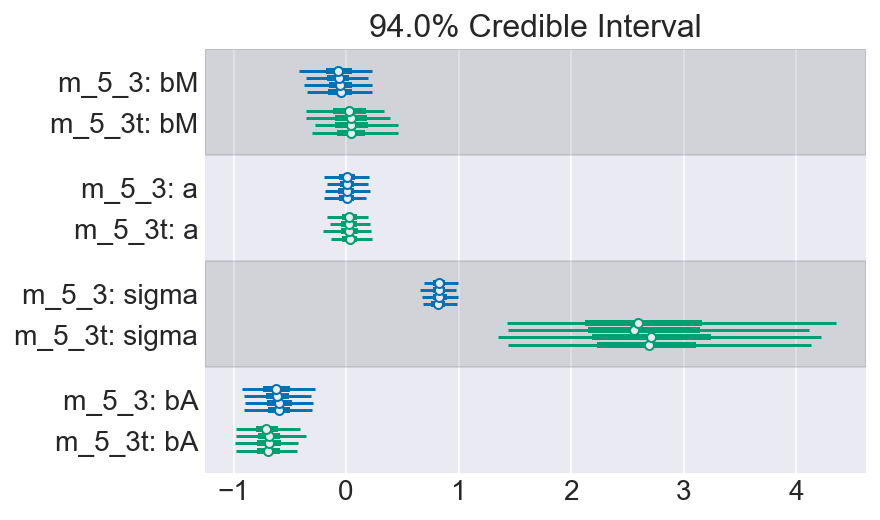

In [34]:
az.plot_forest([m_5_3_trace, m_5_3t_trace], model_names=["m_5_3", "m_5_3t"], figsize=[6, 3.5]);

/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/stats/stats.py:1194: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


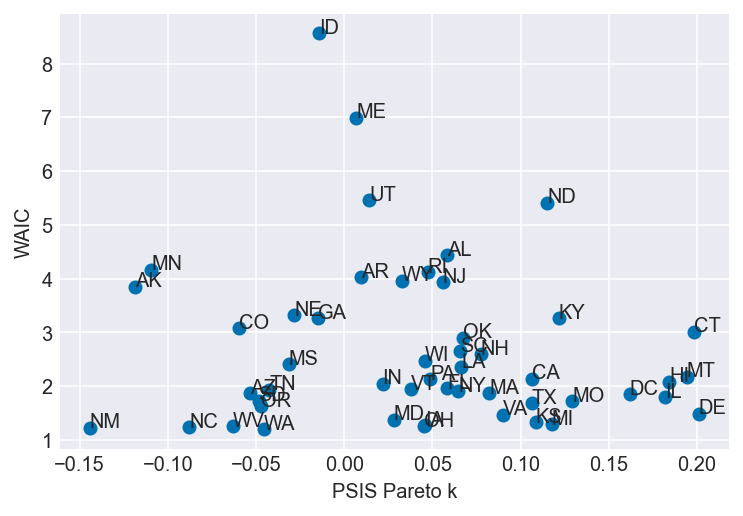

In [37]:
psis_m_5_3 = az.loo(m_5_3t_trace, pointwise=True, scale="deviance")
waic_m_5_3 = az.waic(m_5_3t_trace, pointwise=True, scale="deviance")

# Figure 7.10
plt.scatter(psis_m_5_3.pareto_k, waic_m_5_3.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC");



for i in range(len(psis_m_5_3.pareto_k)):
    plt.annotate(d['Loc'].iloc[i], (psis_m_5_3.pareto_k[i], waic_m_5_3.waic_i[i]))